# MNIST - NN - PyTorch

- [Сургалтанд шаардлагатай зүйлс](#Сургалтанд-шаардлагатай-зүйлс)
    * [Сургалтын өгөгдөл унших](#Сургалтын-өгөгдөл-унших)
    * [Accuracy тооцоолох функц](#Accuracy-тооцоолох-функц)
    * [Сургалт явуулах ерөнхий функц](#Сургалт-явуулах-ерөнхий-функц)
- [Сургалт](#Сургалт)
    * [1. Энгийн Neural Network](#1.-Энгийн-Neural-Network)
    * [2. Энгийн Neural Network (sigmoid)](#2.-Энгийн-Neural-Network-(sigmoid))
    * [3. Олон давхаргатай Neural Network](#3.-Олон-давхаргатай-Neural-Network)
    * [4. Neural Network with Dropout](#4.-Neural-Network-with-Dropout)

In [1]:
import torch
from torch import nn
from torch import optim
import matplotlib.pyplot as plt
import helper
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## Сургалтанд шаардлагатай зүйлс

### Сургалтын өгөгдөл унших

In [2]:
from torchvision import datasets, transforms

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0,), (1,)),])

trainset = datasets.MNIST('.', download=False, train=True, transform=transform)
testset = datasets.MNIST('.', download=False, train=False, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=150, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=150, shuffle=True)
print('Сургах өгөгдөл:', len(trainset))
print('Шалгах өгөгдөл:', len(testset))
print('Batch тоо:', len(trainloader))
batch_count = len(trainloader)

Сургах өгөгдөл: 60000
Шалгах өгөгдөл: 10000
Batch тоо: 400


### Accuracy тооцоолох функц

In [3]:
def get_accuracy(predicted, target):
    equals = predicted.max(1)[1] == target
    return torch.mean(equals.type(torch.FloatTensor)).item()

### Сургалт явуулах ерөнхий функц

**Параметрууд**
- `model` - сургах модель
- `criterion` - loss функц
- `optimizer` - optimizer
- `epoch` - epoch тоо

**Буцаах утга**
- `model` - сургасан модель
- `train_losses` - сургалтын өгөгдлийн loss
- `test_losses` - туршилтын өгөгдлийн loss

In [4]:
def train(model, criterion, optimizer, epoch):
    train_losses, test_losses = [], []

    for e in range(epoch):
        batch_n = 1
        epoch_loss = 0
        epoch_accuracy = 0
        print(f'Epoch: {e+1}/{epoch}')

        for images, labels in trainloader:
            optimizer.zero_grad()

            log_ps = model(images)
            loss = criterion(log_ps, labels)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            epoch_accuracy += get_accuracy(log_ps, labels)

            helper.print_progress(batch_n, batch_count, loss=epoch_loss/batch_n, accuracy=epoch_accuracy*(100/batch_n))
            batch_n += 1
        else:
            test_loss = 0
            accuracy = 0
            with torch.no_grad():
                model.eval()
                for images, labels in testloader:
                    log_ps = model(images)
                    test_loss += criterion(log_ps, labels)

                    ps = torch.exp(log_ps)
                    accuracy += get_accuracy(ps, labels)
            model.train()

            train_losses.append(epoch_loss/len(trainloader))
            test_losses.append(test_loss/len(testloader))

            print("\n\tTraining Loss: {:.3f}.. ".format(epoch_loss/len(trainloader)),
                  "Test Loss: {:.3f}.. ".format(test_loss/len(testloader)),
                  "Test Accuracy: {:.3f}\n".format(accuracy/len(testloader)))
    return model, train_losses, test_losses

## Сургалт

### 1. Энгийн Neural Network

1 Hidden Layer

**Model:** Input(784) -> Linear(150) -> ReLU -> Linear(10) -> Softmax

**Loss:** Negative Log Likelihood Loss

**Optimizer:** Stochastic Gradient Descend, `lr=0.9`, `momentum=0.9`

**Training**: `epoch=10`, `batch_size=150`

In [5]:
# Оролт
input_size = 784
# Нуугдмал давхарга
hidden_size = 150
# Гаралт
output_size = 10

In [6]:
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(nn.Linear(input_size, hidden_size),
                                    nn.ReLU(),
                                    nn.Linear(hidden_size, output_size),
                                    nn.LogSoftmax(dim=1))
    def forward(self, x):
        x = x.view(x.shape[0], -1)
        x = self.layers(x)
        return x

In [7]:
model = Classifier()
criterion = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.09, momentum=0.9)

In [8]:
model, train_losses, test_losses = train(model, criterion, optimizer, epoch=10)

Epoch: 1/10
[============================================================] 100.0% 400/400 loss*: 0.322 accuracy*: 90.485%
	Training Loss: 0.322..  Test Loss: 0.151..  Test Accuracy: 0.956

Epoch: 2/10
[============================================================] 100.0% 400/400 loss*: 0.123 accuracy*: 96.413%
	Training Loss: 0.123..  Test Loss: 0.096..  Test Accuracy: 0.970

Epoch: 3/10
[============================================================] 100.0% 400/400 loss*: 0.084 accuracy*: 97.488%
	Training Loss: 0.084..  Test Loss: 0.092..  Test Accuracy: 0.972

Epoch: 4/10
[============================================================] 100.0% 400/400 loss*: 0.065 accuracy*: 98.072%
	Training Loss: 0.065..  Test Loss: 0.081..  Test Accuracy: 0.975

Epoch: 5/10
[============================================================] 100.0% 400/400 loss*: 0.052 accuracy*: 98.405%
	Training Loss: 0.052..  Test Loss: 0.077..  Test Accuracy: 0.977

Epoch: 6/10
[==========================================

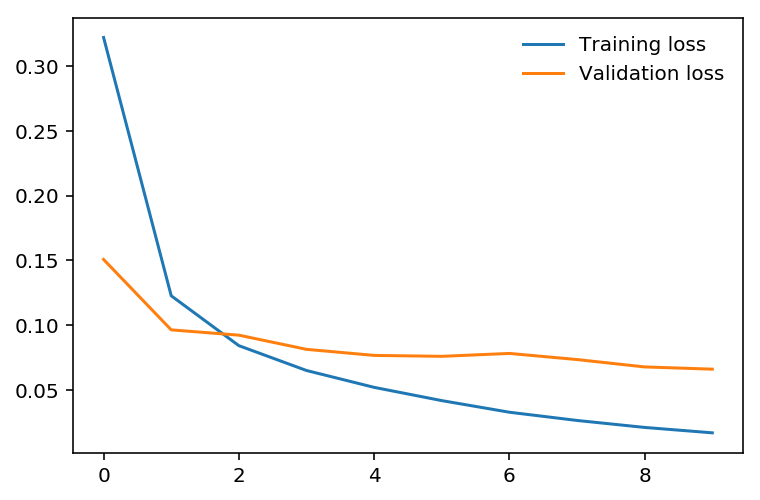

In [9]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)

### 2. Энгийн Neural Network (sigmoid)

1 Hidden Layer

**Model:** Input(784) -> Linear(150) -> Sigmoid -> Linear(10) -> Softmax

**Loss:** Negative Log Likelihood Loss

**Optimizer:** Stochastic Gradient Descend, `lr=0.9`, `momentum=0.9`

**Training**: `epoch=10`, `batch_size=150`

In [10]:
# Оролт
input_size = 784
# Нуугдмал давхарга
hidden_size = 150
# Гаралт
output_size = 10

In [11]:
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(nn.Linear(input_size, hidden_size),
                                    nn.Sigmoid(),
                                    nn.Linear(hidden_size, output_size),
                                    nn.LogSoftmax(dim=1))
    def forward(self, x):
        x = x.view(x.shape[0], -1)
        x = self.layers(x)
        return x

In [12]:
model = Classifier()
criterion = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.09, momentum=0.9)

In [13]:
model, train_losses, test_losses = train(model, criterion, optimizer, epoch=10)

Epoch: 1/10
[============================================================] 100.0% 400/400 loss*: 0.551 accuracy*: 83.603%
	Training Loss: 0.551..  Test Loss: 0.278..  Test Accuracy: 0.920

Epoch: 2/10
[============================================================] 100.0% 400/400 loss*: 0.262 accuracy*: 92.315%
	Training Loss: 0.262..  Test Loss: 0.225..  Test Accuracy: 0.934

Epoch: 3/10
[============================================================] 100.0% 400/400 loss*: 0.208 accuracy*: 93.953%
	Training Loss: 0.208..  Test Loss: 0.186..  Test Accuracy: 0.945

Epoch: 4/10
[============================================================] 100.0% 400/400 loss*: 0.172 accuracy*: 95.022%
	Training Loss: 0.172..  Test Loss: 0.158..  Test Accuracy: 0.952

Epoch: 5/10
[============================================================] 100.0% 400/400 loss*: 0.146 accuracy*: 95.765%
	Training Loss: 0.146..  Test Loss: 0.140..  Test Accuracy: 0.958

Epoch: 6/10
[==========================================

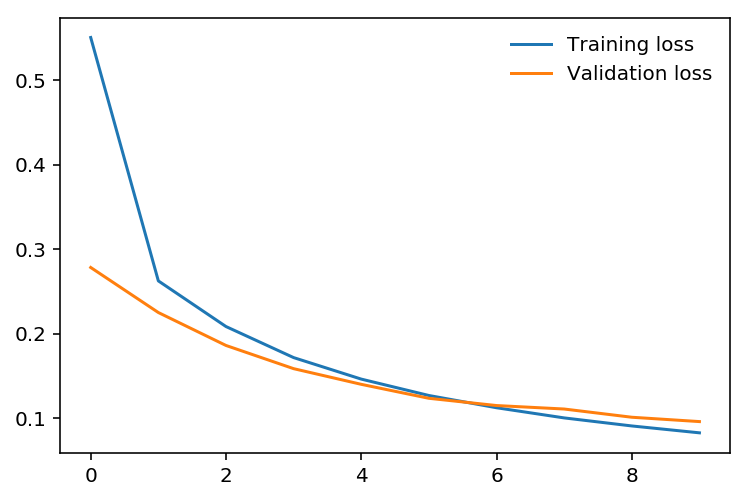

In [14]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)

### 3. Олон давхаргатай Neural Network

2 Hidden Layer

**Model:** Input(784) -> Linear(150) -> ReLU -> Linear(50) -> ReLU -> Linear(10) -> Softmax

**Loss:** Negative Log Likelihood Loss

**Optimizer:** Stochastic Gradient Descend, `lr=0.9`, `momentum=0.9`

**Training**: `epoch=10`, `batch_size=150`

In [27]:
input_size = 784
hidden_sizes = [150, 50]
output_size = 10

In [28]:
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(nn.Linear(input_size, hidden_sizes[0]),
                                    nn.ReLU(),
                                    nn.Linear(hidden_sizes[0], hidden_sizes[1]),
                                    nn.ReLU(),
                                    nn.Linear(hidden_sizes[1], output_size),
                                    nn.LogSoftmax(dim=1))
    def forward(self, x):
        x = x.view(x.shape[0], -1)
        x = self.layers(x)
        return x

In [29]:
model = Classifier()
criterion = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.09, momentum=0.9)

In [30]:
model, train_losses, test_losses = train(model, criterion, optimizer, epoch=10)

Epoch: 1/10
[============================================================] 100.0% 400/400 loss*: 0.357 accuracy*: 89.093%
	Training Loss: 0.357..  Test Loss: 0.149..  Test Accuracy: 0.952

Epoch: 2/10
[============================================================] 100.0% 400/400 loss*: 0.108 accuracy*: 96.668%
	Training Loss: 0.108..  Test Loss: 0.102..  Test Accuracy: 0.968

Epoch: 3/10
[============================================================] 100.0% 400/400 loss*: 0.080 accuracy*: 97.503%
	Training Loss: 0.080..  Test Loss: 0.096..  Test Accuracy: 0.971

Epoch: 4/10
[============================================================] 100.0% 400/400 loss*: 0.061 accuracy*: 98.023%
	Training Loss: 0.061..  Test Loss: 0.081..  Test Accuracy: 0.975

Epoch: 5/10
[============================================================] 100.0% 400/400 loss*: 0.046 accuracy*: 98.558%
	Training Loss: 0.046..  Test Loss: 0.089..  Test Accuracy: 0.974

Epoch: 6/10
[==========================================

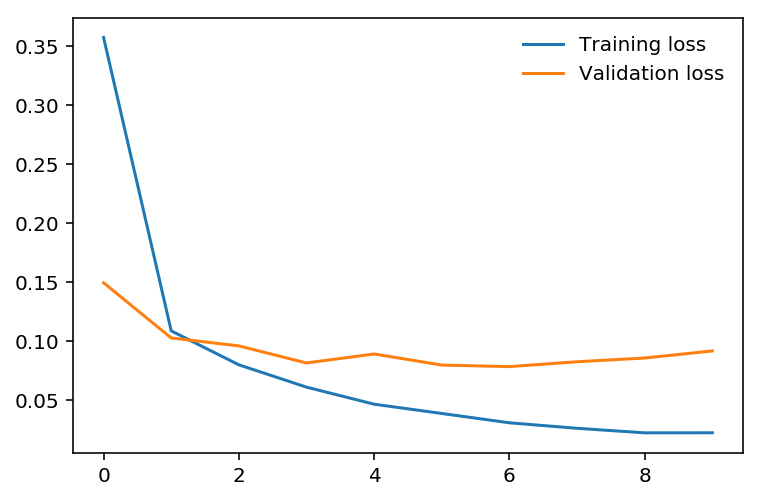

In [31]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)

### 4. Neural Network with Dropout

2 Hidden Layer + Dropout

**Model:** Input(784) -> Linear(150) -> ReLU -> Dropout(0.2) -> Linear(50) -> ReLU -> Dropout(0.2) -> Linear(10) -> Softmax

**Loss:** Negative Log Likelihood Loss

**Optimizer:** Stochastic Gradient Descend, `lr=0.9`, `momentum=0.9`

**Training**: `epoch=10`, `batch_size=150`

In [32]:
input_size = 784
hidden_sizes = [150, 50]
output_size = 10

In [33]:
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(nn.Linear(input_size, hidden_sizes[0]),
                                    nn.ReLU(),
                                    nn.Dropout(0.2),
                                    nn.Linear(hidden_sizes[0], hidden_sizes[1]),
                                    nn.ReLU(),
                                    nn.Dropout(0.2),
                                    nn.Linear(hidden_sizes[1], output_size),
                                    nn.LogSoftmax(dim=1))
    def forward(self, x):
        x = x.view(x.shape[0], -1)
        x = self.layers(x)
        return x

In [34]:
model = Classifier()
criterion = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.09, momentum=0.9)

In [35]:
model, train_losses, test_losses = train(model, criterion, optimizer, epoch=10)

Epoch: 1/10
[============================================================] 100.0% 400/400 loss*: 0.449 accuracy*: 86.058%
	Training Loss: 0.449..  Test Loss: 0.153..  Test Accuracy: 0.954

Epoch: 2/10
[============================================================] 100.0% 400/400 loss*: 0.178 accuracy*: 94.785%
	Training Loss: 0.178..  Test Loss: 0.113..  Test Accuracy: 0.966

Epoch: 3/10
[============================================================] 100.0% 400/400 loss*: 0.140 accuracy*: 95.823%
	Training Loss: 0.140..  Test Loss: 0.096..  Test Accuracy: 0.971

Epoch: 4/10
[============================================================] 100.0% 400/400 loss*: 0.119 accuracy*: 96.432%
	Training Loss: 0.119..  Test Loss: 0.095..  Test Accuracy: 0.972

Epoch: 5/10
[============================================================] 100.0% 400/400 loss*: 0.109 accuracy*: 96.722%
	Training Loss: 0.109..  Test Loss: 0.092..  Test Accuracy: 0.972

Epoch: 6/10
[==========================================

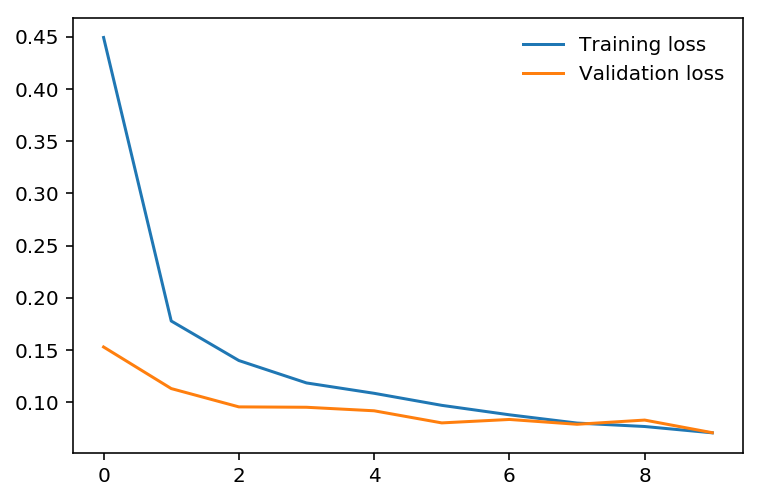

In [36]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)